In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from py.Dataset import Dataset
from py.DatasetStatistics import DatasetStatistics
from py.Session import Session, MotionImage, LapseImage
from py.FileUtils import list_folders, list_jpegs_recursive
from py.ImageUtils import display_images

In [2]:
DIR = '/home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/'

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 32 sessions
Session 'Beaver_01' at folder: /home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


In [309]:
img = session.get_random_motion_image(day_only=True)

In [310]:
previous_img, next_img, rel = img.get_closest_lapse_images()
print(rel)

0.14277777777777778


In [311]:
scale = 0.5
gray = True
img1 = previous_img.read(gray=gray, scale=scale)
img2 = img.read(gray=gray, scale=scale)
img3 = next_img.read(gray=gray, scale=scale)
# previous_img.open()
# img.open()
# next_img.open()

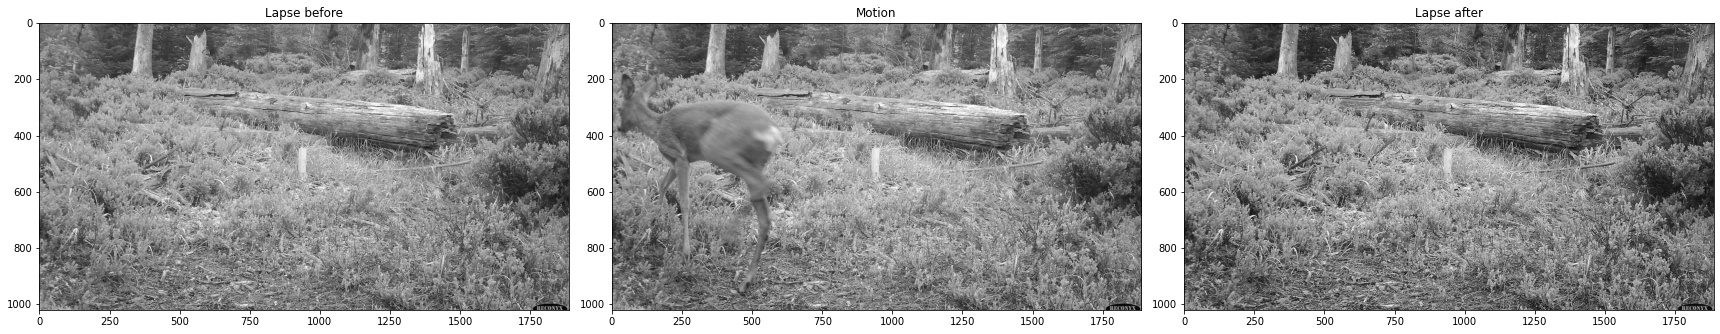

In [312]:
kwargs = { "cmap": "gray" } if gray else {}
display_images([img1, img2, img3], ["Lapse before", "Motion", "Lapse after"], **kwargs)

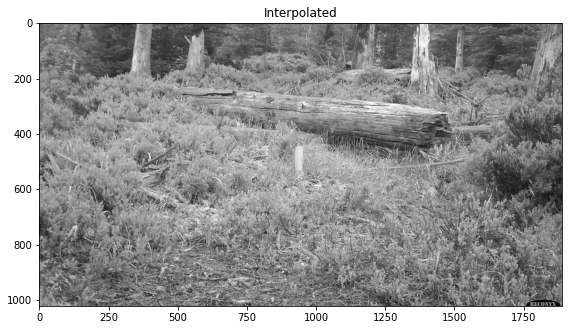

In [313]:
interpol = rel * img3 + (1 - rel) * img1
display_images([interpol], ["Interpolated"], **kwargs)

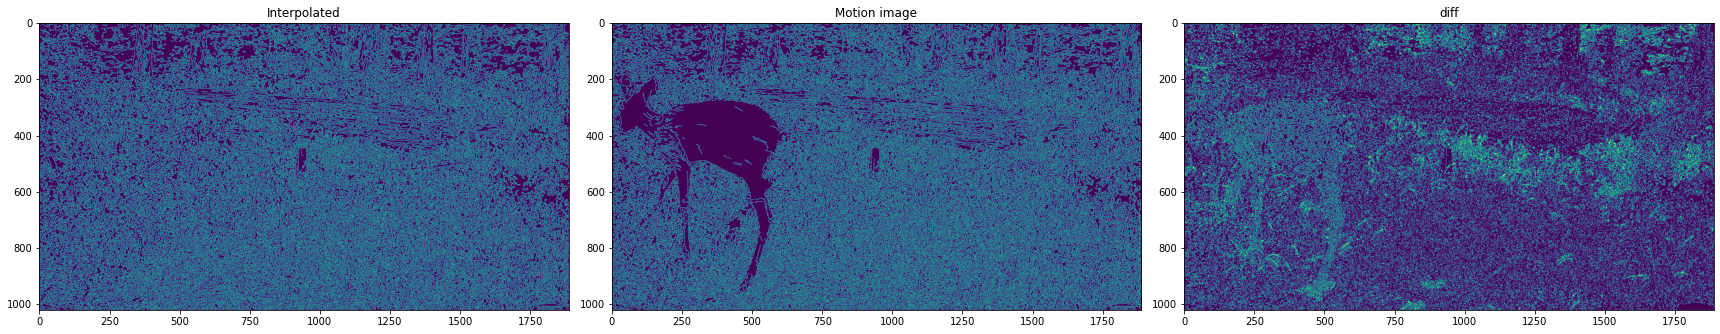

0.26714246326577995
0.2641464061826263
0.19672553401439516


In [316]:
from skimage.metrics import structural_similarity
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import canny
cinterpol = canny(interpol)
cimg2 = canny(img2)
display_images([cinterpol, cimg2, cimg2 ^ cinterpol], ["Interpolated", "Motion image", "diff"])
print(np.average(cinterpol))
print(np.average(cimg2))
print(np.average(cimg2 ^ cinterpol))

In [317]:
def normalize(img):
    return (img - np.mean(img)) / np.std(img)

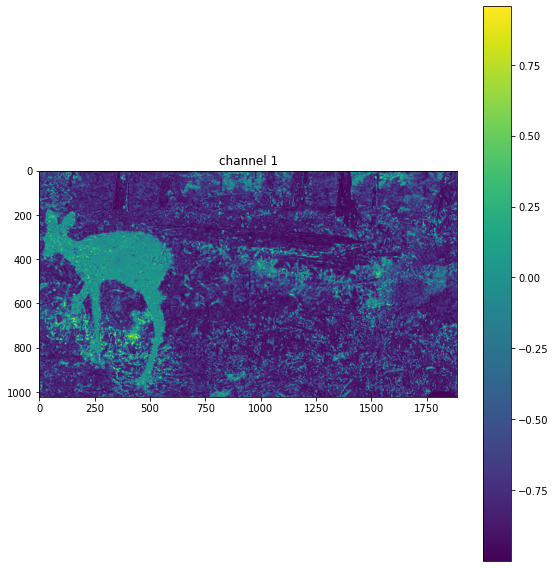

0.6231354639855707


In [319]:
if gray:
    mssim, S = structural_similarity(normalize(interpol), normalize(img2), full=True)
    display_images([-S], ["channel 1"], colorbar=True)
    print(mssim)
else:
    mssim, S = structural_similarity(normalize(interpol), normalize(img2), full=True, multichannel=True)
    display_images([-S[:,:,0], -S[:,:,0], -S[:,:,0]], ["channel 1", "channel 2", "channel 3"], colorbar=True)
    print(mssim)

In [320]:
def threshold(img, thr):
    return img * (img >= thr)

def mask(img, thr):
    return img >= thr

In [324]:
diff = (img2 - img1) ** 2
diff_test = (img1 - interpol) ** 2
print(np.average(diff))
print(np.average(diff_test))

0.006843790594373222
0.0006956106845997996


In [322]:
S_ = mask(-S[:,:,0], -0.2)
plt.imshow(S_)
print(np.average(S_))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [168]:
from scipy.ndimage.morphology import binary_closing, binary_erosion

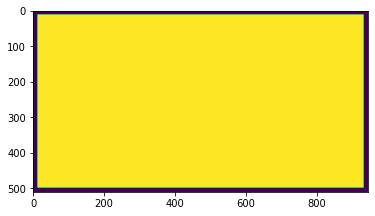

In [169]:
S_er = binary_closing(S_, structure=np.ones((9,9)), iterations=3)
plt.imshow(S_er)

In [4]:
from py.ImageClassifier import AbstractImageClassifier

class AbsDiffClassifier(AbstractImageClassifier):
    def evaluate(self, motion_img: MotionImage, display=False):
        before_img, after_img, rel = motion_img.get_closest_lapse_images()
        comp_img = before_img if rel <= 0.5 else after_img
        motion_arr = motion_img.read(scale=0.5, gray=True)
        comp_arr = comp_img.read(scale=0.5, gray=True)

        diff = (motion_arr - comp_arr) ** 2
        val = np.average(diff)

        if display:
            display_images([motion_arr, comp_arr, diff], ["Motion image", "Closest lapse image", f"avg sq diff = {val}"], cmap="gray")

        return val

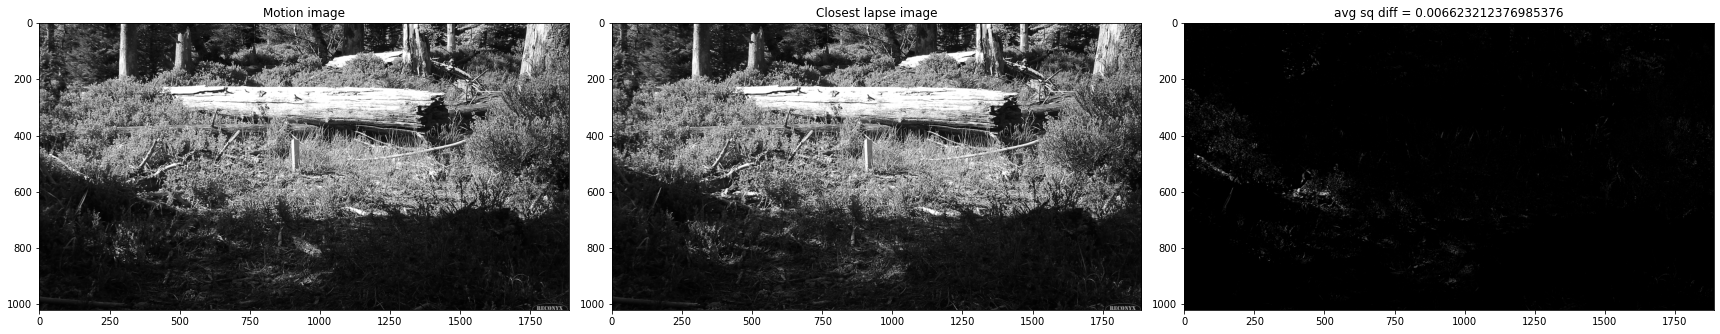

0.006623212376985376

In [8]:
img = session.get_random_motion_image(day_only=True)
classifier = AbsDiffClassifier()
classifier.evaluate(img, display=True)

In [14]:
import ipywidgets as widgets
from IPython.display import display

class ImageAnnotator():
    def __init__(self, classifier: AbstractImageClassifier, session: Session, initial_scores = [], initial_annotations = []):
        self.scores = initial_scores
        self.annotations = initial_annotations
        self.score = -1
        self.classifier = classifier
        self.session = session
        normal_btn = widgets.Button(description = "Normal")
        anomalous_btn = widgets.Button(description = "Anomalous")
        self.button_box = widgets.HBox([normal_btn, anomalous_btn])
        self.output = widgets.Output(layout={"height": "400px"})
        display(self.button_box, self.output)
        normal_btn.on_click(self.mark_as_normal)
        anomalous_btn.on_click(self.mark_as_anomalous)
        self.next_image()
    
    def mark_as_normal(self, _):
        with self.output:
            print("Marking as normal...")
        self.annotations.append(True)
        self.scores.append(self.score)
        self.next_image()
    
    def mark_as_anomalous(self, _):
        with self.output:
            print("Marking as anomalous...")
        self.annotations.append(False)
        self.scores.append(self.score)
        self.next_image()
    
    def next_image(self):
        img = self.session.get_random_motion_image(day_only=True)
        self.score = self.classifier.evaluate(img)
        self.output.clear_output()
        with self.output:
            display(img.to_ipython_image())
            print(f"score = {self.score}")


In [18]:
annotator = ImageAnnotator(AbsDiffClassifier(), session, initial_scores=annotator.scores, initial_annotations=annotator.annotations)

Output(layout=Layout(height='400px'))

In [19]:
np.save("annotations.npy", [annotator.annotations, annotator.scores])

In [21]:
data = np.load("annotations.npy")
data

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.04106169, 0.07320884, 0.06721638, 0.02182765, 0.0340965 ,
        0.02000366, 0.02940218, 0.03074892, 0.04367824, 0.03088665,
        0.03074892, 0.078383  , 0.02000366, 0.01949857, 0.02916867,
        0.07510512, 0.07904947, 0.04788776, 0.00349494, 0.03657243,
        0.00766623, 0.03088665, 0.00654453, 0.05281735, 0.0430545 ,
        0.03838451, 0.02773

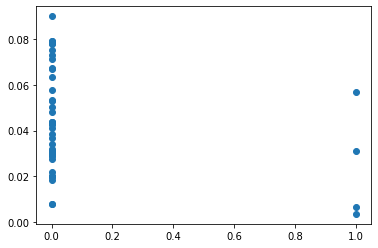

In [23]:
plt.scatter(data[0], data[1])